<a href="https://colab.research.google.com/github/ollpp/Project/blob/master/Section4/AI_12_%EB%B0%95%EC%84%9D%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.3 MB/s 


In [66]:
!pip install -q "tqdm>=4.36.1"

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

In [72]:
# 딥러닝을 위한 라이브러리
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_addons as tfa
import tqdm


# EDA를 위한 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# file drivein을 위한 라이브러리
from google.colab import drive

In [73]:
# 시드 고정

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data path
file_path = '/content/drive/MyDrive/Section4/train.csv'
df = pd.read_csv(file_path)

# data EDA

In [4]:
df.shape

(10407, 4)

In [5]:
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [6]:
df['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

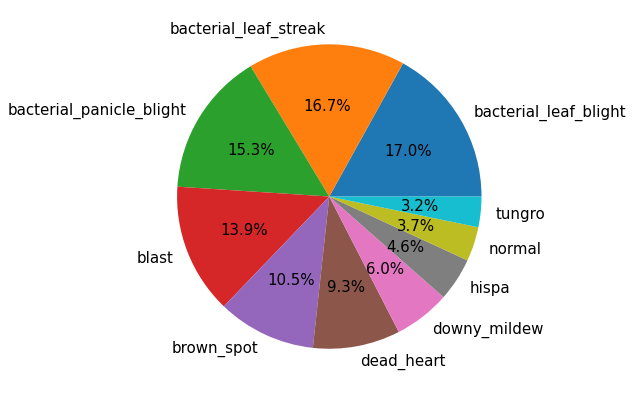

In [7]:
# graph visualization
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# target label
label = list(df['label'].unique())

# pie graph
plt.pie(df['label'].value_counts(), labels=label, autopct='%.1f%%')
plt.show()

In [8]:
train, test = train_test_split(df, test_size = 0.1, stratify=df['label'], random_state=42)

In [9]:
train.shape, test.shape

((9366, 4), (1041, 4))

In [10]:
train['label'].value_counts()

normal                      1588
blast                       1564
hispa                       1435
dead_heart                  1298
tungro                       979
brown_spot                   868
downy_mildew                 558
bacterial_leaf_blight        431
bacterial_leaf_streak        342
bacterial_panicle_blight     303
Name: label, dtype: int64

In [11]:
test['label'].value_counts()

normal                      176
blast                       174
hispa                       159
dead_heart                  144
tungro                      109
brown_spot                   97
downy_mildew                 62
bacterial_leaf_blight        48
bacterial_leaf_streak        38
bacterial_panicle_blight     34
Name: label, dtype: int64

# Data manipulating

In [43]:
# 균형있는 data split을 위한 작업 진행

paths = []
labels = []

for root, dirs, filename in os.walk('/content/drive/MyDrive/Section4/train_images'):
    
    # root directory를 제외하고 각 diretory 중 image가 있으면 레이블링 진행
    for name in filename:
        if '.jpg' in name:
            path = root + '/' + name
            paths.append(path)

            if 'brown_spot' in path:
                labels.append('brown_spot')

            elif 'downy_mildew' in path:
                labels.append('downy_mildew')

            elif 'bacterial_leaf_blight' in path:
                labels.append('bacterial_leaf_blight')

            elif 'hispa' in path:
                labels.append('hispa')

            elif 'bacterial_panicle_blight' in path:
                labels.append('bacterial_panicle_blight')

            elif 'bacterial_leaf_streak' in path:
                labels.append('bacterial_leaf_streak')

            elif 'blast' in path:
                labels.append('blast')

            elif 'dead_heart' in path:
                labels.append('dead_heart')

            elif 'tungro' in path:
                labels.append('tungro')

            elif 'normal' in path:
                labels.append('normal')
                
            else:
                labels.append('N/A')

data_df = pd.DataFrame({'path':paths, 'label':labels})

In [45]:
data_df.shape

(10426, 2)

In [28]:
data_df['label'].value_counts()

normal                      1764
blast                       1757
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [51]:
train_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df['label'], random_state=42)

In [53]:
train_df.shape, test_df.shape

((9383, 2), (1043, 2))

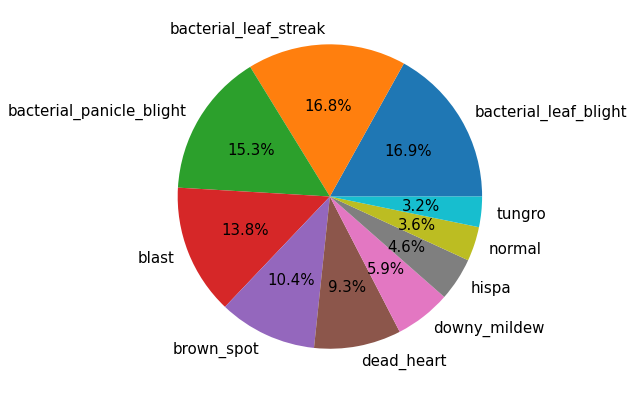

In [56]:
# graph visualization
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# pie graph
plt.pie(train_df['label'].value_counts(), labels=label, autopct='%.1f%%')
plt.show()

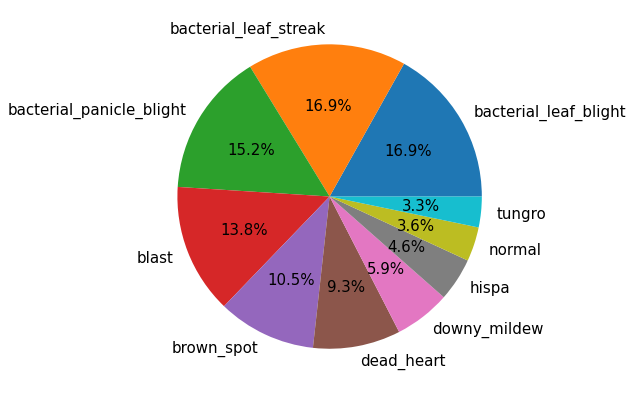

In [55]:
# graph visualization
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# pie graph
plt.pie(test_df['label'].value_counts(), labels=label, autopct='%.1f%%')
plt.show()

In [57]:
train, val = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [58]:
train.shape, val.shape

((7506, 2), (1877, 2))

In [99]:
# 데이터 종류에 맞게 ImageDataGenerator 객체 생성
tr_gen = ImageDataGenerator(horizontal_flip=True, rescale=1/255., shear_range=0.2, zoom_range=0.2)
val_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

# 데이터 종류에 맞는 Pandas.DataFrame으로부터 Numpy Array Iterator 생성
tr_flow_gen = tr_gen.flow_from_dataframe(dataframe=train, x_col='path', y_col='label',
                                        target_size=(256, 256), class_mode='sparse',
                                        shuffle=True)
val_flow_gen = val_gen.flow_from_dataframe(dataframe=val, x_col='path', y_col='label',
                                          target_size=(256, 256), class_mode='sparse',
                                          shuffle=False)
test_flow_gen = test_gen.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label',
                                            target_size=(256, 256), class_mode='sparse',
                                            suffle=False)

Found 7506 validated image filenames belonging to 10 classes.
Found 1877 validated image filenames belonging to 10 classes.
Found 1043 validated image filenames belonging to 10 classes.


In [61]:
# baseline model 정의
def create_bs_model(verbose=False):
    bs_model = Sequential([
                Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(256, 256, 3)),
                MaxPooling2D(2, 2),
                Conv2D(128, (3, 3), padding='same', activation='relu'),
                Flatten(),
                Dense(256, activation='relu'),
                Dense(10, activation='softmax')
    ])

    if verbose:
        bs_model.summary()

    return bs_model

In [62]:
bs_model = create_bs_model(verbose=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 flatten (Flatten)           (None, 2097152)           0         
                                                                 
 dense (Dense)               (None, 256)               536871168 
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

In [63]:
bs_model.compile(optimizer=Adam(lr=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [69]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

bs_model.fit(tr_flow_gen, epochs=1, validation_data=val_flow_gen, callbacks=[tqdm_callback])

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/118           ETA: ?s - 

118/118 [==============================] - 3745s 32s/step - loss: 1.9498 - accuracy: 0.3119 - val_loss: 1.7800 - val_accuracy: 0.3863


In [70]:
bs_model.evaluate(test_flow_gen)

17/17 [==============================] - 459s 29s/step - loss: 1.7540 - accuracy: 0.3941


[1.7539544105529785, 0.3940556049346924]

In [74]:
# 사전학습 모델 사용

pretrained_model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [100]:
# 사전 학습 모델 위에 완전 연결 신경망 추가
# VGG

model_vgg = Sequential()
model_vgg.add(pretrained_model)
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Dense(128,activation='relu'))
model_vgg.add(Dense(10,activation='softmax'))

model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,781,642
Trainable params: 14,781,642
Non-trainable params: 0
_________________________________________________________________


In [101]:
model_vgg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
model_vgg.fit(tr_flow_gen,
          validation_data=val_flow_gen,
          callbacks=[tqdm_callback],
          epochs=10)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/235           ETA: ?s - 

Epoch 1/10
235/235 [==============================] - 205s 869ms/step - loss: 2.1059 - accuracy: 0.2225 - val_loss: 1.9944 - val_accuracy: 0.2552
Epoch 2/10


0/235           ETA: ?s - 

Epoch 2/10
235/235 [==============================] - 204s 868ms/step - loss: 1.9312 - accuracy: 0.3002 - val_loss: 1.7249 - val_accuracy: 0.3980
Epoch 3/10


0/235           ETA: ?s - 

Epoch 3/10
235/235 [==============================] - 203s 864ms/step - loss: 1.6492 - accuracy: 0.4334 - val_loss: 1.5683 - val_accuracy: 0.4566
Epoch 4/10


0/235           ETA: ?s - 

Epoch 4/10
235/235 [==============================] - 204s 866ms/step - loss: 1.4996 - accuracy: 0.4840 - val_loss: 1.4372 - val_accuracy: 0.5147
Epoch 5/10


0/235           ETA: ?s - 

Epoch 5/10
235/235 [==============================] - 205s 870ms/step - loss: 1.4024 - accuracy: 0.5147 - val_loss: 1.3316 - val_accuracy: 0.5466
Epoch 6/10


0/235           ETA: ?s - 

Epoch 6/10
235/235 [==============================] - 205s 873ms/step - loss: 1.3459 - accuracy: 0.5334 - val_loss: 1.3234 - val_accuracy: 0.5445
Epoch 7/10


0/235           ETA: ?s - 

Epoch 7/10
235/235 [==============================] - 206s 874ms/step - loss: 1.2743 - accuracy: 0.5549 - val_loss: 1.2722 - val_accuracy: 0.5743
Epoch 8/10


0/235           ETA: ?s - 

Epoch 8/10
235/235 [==============================] - 208s 882ms/step - loss: 1.2788 - accuracy: 0.5596 - val_loss: 1.4669 - val_accuracy: 0.5535
Epoch 9/10


0/235           ETA: ?s - 

Epoch 9/10
235/235 [==============================] - 207s 879ms/step - loss: 1.2561 - accuracy: 0.5581 - val_loss: 1.2461 - val_accuracy: 0.5850
Epoch 10/10


0/235           ETA: ?s - 

Epoch 10/10
235/235 [==============================] - 204s 865ms/step - loss: 1.1854 - accuracy: 0.5889 - val_loss: 1.1485 - val_accuracy: 0.6201


In [104]:
model_vgg.evaluate(test_flow_gen)

33/33 [==============================] - 11s 319ms/step - loss: 1.0634 - accuracy: 0.6232


[1.0634433031082153, 0.6232023239135742]

In [ ]:
# 사전 학습 모델 U-net

OUTPUT_CHANNELS=3


model_unet = tf.keras.applications.ResNet50(input_shape=[256, 256, 3], include_top=False)

layer_names = [
    'conv1_relu', # 64x64
    'conv2_block3_out', # 32x32 
    'conv3_block4_out', # 16x16
    'conv4_block6_out',  # 8x8
    'conv5_block3_out',      # 4x4
]
layers = [model_unet.get_layer(name).output for name in layer_names]


down_stack = tf.keras.Model(inputs=model_unet.input, outputs=layers)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def resnet_model(output_channels):
    """
    모델을 정의하는 함수입니다.
    """
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling을 진행하는 부분입니다.
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling을 진행하는 부분입니다.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # Downsampling 결과를 Concatenate 해줍니다.
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # 출력되는 이미지 크기를 동일하게 하기 위해 마지막 층을 구현합니다.
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model_resnet = resnet_model(OUTPUT_CHANNELS)

In [ ]:
model_resnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_resnet.summary()

In [ ]:
model_resnet.fit(tr_flow_gen,
          batch_size=128,
          validation_data=val_flow_gen,
          callbacks=[tqdm_callback],
          epochs=2)

In [82]:
from tensorflow.keras.datasets import cifar10



(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [83]:
X_train.shape

(50000, 32, 32, 3)

In [84]:
y_train.shape

(50000, 1)

In [91]:
a, b = tr_flow_gen.next()

In [92]:
a.shape

(32, 256, 256, 3)

In [87]:
b.shape

(64,)

In [88]:
a

array([[[[0.16470589, 0.20392159, 0.        ],
         [0.2509804 , 0.39607847, 0.03137255],
         [0.6431373 , 0.8313726 , 0.19607845],
         ...,
         [0.94117653, 0.9725491 , 0.06666667],
         [0.62352943, 0.7019608 , 0.        ],
         [0.41176474, 0.49411768, 0.03529412]],

        [[0.15686275, 0.20392159, 0.        ],
         [0.1137255 , 0.2392157 , 0.        ],
         [0.39607847, 0.5686275 , 0.        ],
         ...,
         [0.9607844 , 0.9960785 , 0.05882353],
         [0.7568628 , 0.8431373 , 0.03921569],
         [0.41960788, 0.5019608 , 0.        ]],

        [[0.12156864, 0.19215688, 0.        ],
         [0.15686275, 0.24313727, 0.09019608],
         [0.21176472, 0.3254902 , 0.        ],
         ...,
         [0.909804  , 0.9568628 , 0.        ],
         [0.8235295 , 0.91372555, 0.01176471],
         [0.5294118 , 0.62352943, 0.        ]],

        ...,

        [[0.15294118, 0.24705884, 0.0509804 ],
         [0.0627451 , 0.15686275, 0.        ]

In [89]:
b

array([3., 8., 5., 0., 3., 5., 4., 8., 8., 3., 2., 0., 7., 7., 5., 3., 5.,
       5., 7., 6., 5., 8., 9., 8., 8., 3., 2., 8., 4., 6., 4., 5., 8., 7.,
       0., 3., 3., 0., 3., 7., 4., 6., 3., 6., 8., 7., 3., 6., 7., 7., 7.,
       2., 8., 5., 5., 7., 8., 7., 1., 9., 4., 0., 6., 9.], dtype=float32)

In [93]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = image_generator.flow_from_directory(
    '/content/drive/MyDrive/Section4/mountainForest/train',
    class_mode = 'binary',
    batch_size = 64
)

val_data_gen= image_generator.flow_from_directory(
    '/content/drive/MyDrive/Section4/mountainForest/validation',
     class_mode = 'binary',
    batch_size = 64
)

Found 533 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


In [95]:
a, b = train_data_gen.next()

In [96]:
a.shape

(64, 256, 256, 3)

In [ ]:
i=0
for root, dirs, filename in os.walk('/content/drive/MyDrive/Section4/mountainForest/train'):
    
    # root directory를 제외하고 각 diretory 중 image가 있으면 레이블링 진행
    for name in filename:
        print(i)
        i+=1